# Lab 7: Heart Attack

### The Data

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import make_scorer, roc_auc_score

import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha = ha.dropna()
#No missing values, might check for outliers
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


### Outliers
Went through and calculated any outliers for each of the numerical variables. While there were a handful in each of the variables, none of the values seemed to be a calculation or measurement error, so I did not remove any outliers

In [3]:
ha.rename(columns={'output': 'atrisk', 'cp': 'chestpain', 'trtbps': 'rbp', 'thalach': 'maxrate'}, inplace = True)
ha['atrisk'] = ha['atrisk'].astype('category')
ha['sex'] = ha['sex'].astype('category')
ha['chestpain'] = ha['chestpain'].astype('category')
ha['restecg'] = ha['restecg'].astype('category')

# Part One: Fitting Models

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

- Find the best model based on ROC AUC for predicting the target variable.
- Report the (cross-validated!) ROC AUC metric.
- Fit the final model.
- Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.
- (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

In [4]:
X = ha.drop(["atrisk"], axis = 1)
y = ha["atrisk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=13)

In [12]:
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include='category')), 
    ("standardize", StandardScaler(),make_column_selector(dtype_include=np.number)) 
  ],
  remainder = "passthrough"
)

#Attempted another feature set where I did not include 'sex', but it only reduced my scores
ct2 = ColumnTransformer(
  [
    ("keep", FunctionTransformer(lambda x: x), ["chestpain", "restecg", "rbp", "age", "chol", "maxrate"]),
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include='category')), 
    ("standardize", StandardScaler(),make_column_selector(dtype_include=np.number)) 
  ],
  remainder = "passthrough"
)

## Q1: KNN

In [6]:
#Optimizing for K
knn_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("knn", KNeighborsClassifier())]
)

knn_values = [1, 2, 4, 8, 12, 16, 24, 36, 48, 96]

knn_param = {'knn__n_neighbors': knn_values}

gscv =  GridSearchCV(knn_pipeline_1, knn_param, cv=5, scoring = 'roc_auc')

gscv_fitted = gscv.fit(X, y)

roc_auc_scores = gscv_fitted.cv_results_['mean_test_score']

pd.DataFrame(data={"knn values": knn_values, "ROC AUC scores": roc_auc_scores})

,knn values,ROC AUC scores
0,1,0.702285
1,2,0.742794
2,4,0.776119
3,8,0.791621
4,12,0.808792
5,16,0.819611
6,24,0.821157
7,36,0.814428
8,48,0.824325
9,96,0.812824


In [7]:
knn_optimal_pipeline = Pipeline(
  [("preprocessing", ct),
  ("knn", KNeighborsClassifier(n_neighbors=48))]
)

knn_model = knn_optimal_pipeline.fit(X_train, y_train)

knnscore = cross_val_score(knn_model, X, y, cv=5, scoring='roc_auc')

knn_rocauc = knnscore.mean()

print(f"KNN ROC/AUC: {knn_rocauc}")

y_pred_knn = knn_optimal_pipeline.predict(X_test)

#Confusion matrix
knnconf_matrix = confusion_matrix(y_test, y_pred_knn)

# Print the confusion matrix
print("Confusion Matrix:")
print(knnconf_matrix)

KNN ROC/AUC: 0.8243246684350133
Confusion Matrix:
[[70  4]
 [41 49]]


##### Q1: KNN Results
It seems that the best KNN Model is the one with k = 48, resulting in an ROC-AUC value of .8243. This is closer to perfect than it is to being completely random, but it could certainly have a better score.

## Q2: Logistic Regression

In [8]:
log_pipeline = Pipeline(
  [("preprocessing", ct),
  ("log_regression", LogisticRegression())]
)

log_fitted = log_pipeline.fit(X_train, y_train)

#Scores
log_scores = cross_val_score(log_fitted, X, y, cv=5, scoring='roc_auc')

log_rocauc = log_scores.mean()

print(f"Logistic Regression ROC/AUC: {log_rocauc}")

y_pred_log = log_pipeline.predict(X_test)

#Confusion matrix
logconf_matrix = confusion_matrix(y_test, y_pred_log)

# Print the confusion matrix
print("Confusion Matrix:")
print(logconf_matrix)

Logistic Regression ROC/AUC: 0.864367816091954
Confusion Matrix:
[[63 11]
 [23 67]]


In [24]:
# Coefficients
logistic_model = log_pipeline.named_steps['log_regression']

# Retrieve the coefficients and feature names
coefficients = logistic_model.coef_[0]

feature_names = ct.get_feature_names_out()

# Print coefficients with feature names
print("Logistic Model coefficients:")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef}")

Logistic Model coefficients:
dummify__sex_0: 0.7022037026424545
dummify__sex_1: -0.7022053440371269
dummify__chestpain_0: -1.2049569286035926
dummify__chestpain_1: 0.7430253536682061
dummify__chestpain_2: 0.5744431022562854
dummify__chestpain_3: -0.11251316871557075
dummify__restecg_0: -0.09398392481628334
dummify__restecg_1: 0.09398228342161148
standardize__age: -0.3569989104816124
standardize__rbp: -0.18685471578381188
standardize__chol: 0.05708206695894269
standardize__maxrate: 0.5877133788747588


##### Q2: Logistic Regression Results
It seems that the best KNN Model is the one with k = 48, resulting in an ROC-AUC value of .8243. This is closer to perfect than it is to being completely random, but it could certainly have a better score.

## Q3: Decision Tree

In [20]:
#Optimizing for decision tree
decision_tree_pipeline = Pipeline(
  [("preprocessing", ct),
  ("decision_tree_classification", DecisionTreeClassifier())]
)

param_decision_tree = {
    'decision_tree_classification__min_samples_leaf': (1, 5, 10, 15, 30, 32, 35, 38, 40)
}

gscv = GridSearchCV(decision_tree_pipeline, param_decision_tree, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

# Extract the parameters and corresponding ROC AUC scores
params = gscv_fitted.cv_results_['params']
roc_auc_scores = gscv_fitted.cv_results_['mean_test_score']

# Create a DataFrame
pd.DataFrame({"min_samples_leaf": [param['decision_tree_classification__min_samples_leaf'] for param in params],
                          "ROC AUC Scores": roc_auc_scores})

,min_samples_leaf,ROC AUC Scores
0,1,0.699977
1,5,0.781382
2,10,0.795710
3,15,0.801327
4,30,0.813252
5,32,0.815343
6,35,0.819434
7,38,0.792586
8,40,0.792586


In [30]:
#Optimal Decision Tree model

decision_tree_optimal_pipeline = Pipeline(
  [("preprocessing", ct),
  ("decision_tree_classifier", DecisionTreeClassifier(min_samples_leaf = 35))]
)

# Fit the pipeline on the data
decision_tree_optimal_pipeline.fit(X, y)

decision_tree_optimal_pipeline_fitted = decision_tree_optimal_pipeline.fit(X_train, y_train)
y_pred_tree = decision_tree_optimal_pipeline_fitted.predict(X_test)

tree_model = decision_tree_optimal_pipeline_fitted.fit(X_train, y_train)

tree_score = cross_val_score(tree_model, X, y, cv=5, scoring='roc_auc')

tree_rocauc = tree_score.mean()

print(f"Decision Tree ROC/AUC: {tree_rocauc}")

decision_tree_conf_matrix = confusion_matrix(y_test, y_pred_tree)


print("Confusion Matrix:")
print(decision_tree_conf_matrix)

Decision Tree ROC/AUC: 0.8194337754199823
Confusion Matrix:
[[56 18]
 [22 68]]


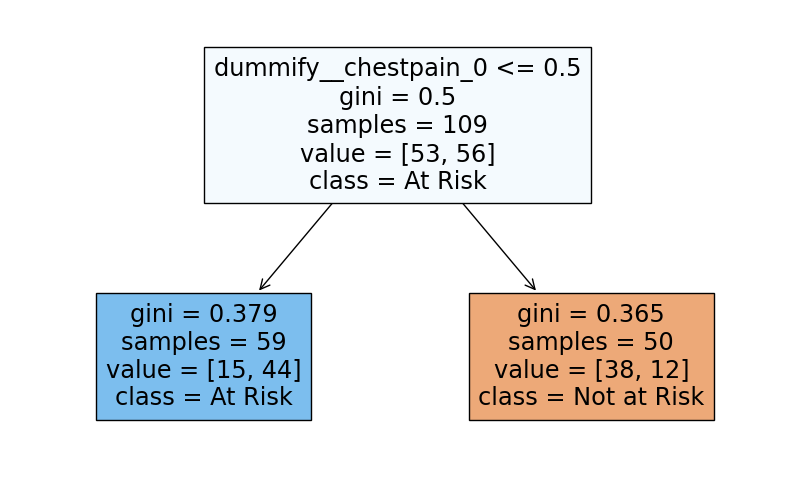

In [32]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the feature names from the preprocessing step
feature_names = decision_tree_optimal_pipeline.named_steps['preprocessing'].get_feature_names_out(input_features=X.columns)

# Convert the array to a list
feature_names_list = feature_names.tolist()

# Extract the DecisionTreeClassifier model from the pipeline
decision_tree_model = decision_tree_optimal_pipeline.named_steps['decision_tree_classifier']

# Plot the tree
plt.figure(figsize=(10, 6))
plot_tree(decision_tree_model, 
          filled=True, 
          feature_names=feature_names_list,
          class_names=['Not at Risk', 'At Risk'])
plt.show()

##### Q3: Decision Tree Results
The best ROC-AUC score is .8194 with min_samples_leaf = 35. It is a somewhat effective model, but the least effective of the 3 tested. 

## Q4: Interpretation

Which predictors were most important to predicting heart attack risk?

- Sex was a significant predictor, as its coefficients were fairly large at +.7022 (male) and -.7022 (female). This suggests that being male is associated with a higher likelihood of being 'at risk', while being female associated with a lower likelihood. This seems to make sense, considering (anecdotally) more men are known to be at risk for a heart attack.

- The dummify__chestpain_0 variable was the only negative of the Chest Pain category, at -1.205. This seems to suggest that anything above a 0 in this category is associated with a higher likelihood of being at risk, since they are all positive coefficients.

- Max heart rate during exercise also seems to have a fairly significant effect, as its coefficient is 0.588, not the largest but still something to consider. 

## Q5: ROC Curve

Plot the ROC Curve for your three models above.

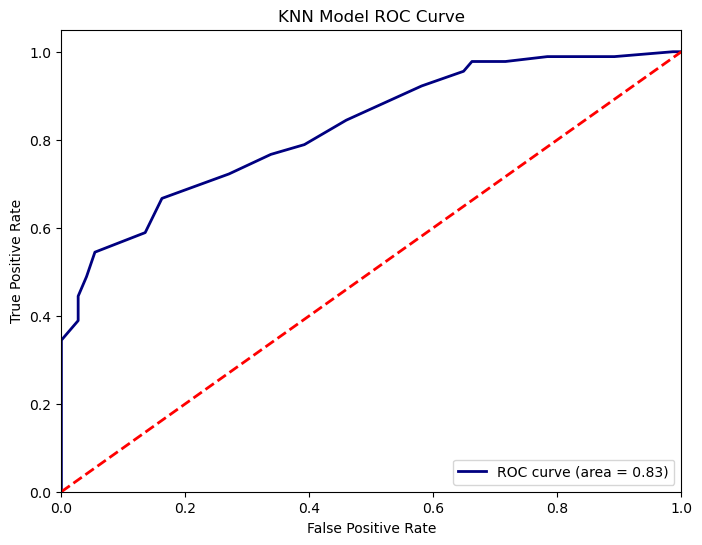

KNN ROC AUC: 0.83


In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Probability predictions
probs = knn_model.predict_proba(X_test)
# Positive outcomes only, 0 to 1
probs = probs[:, 1]

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Model ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"KNN ROC AUC: {roc_auc:.2f}")

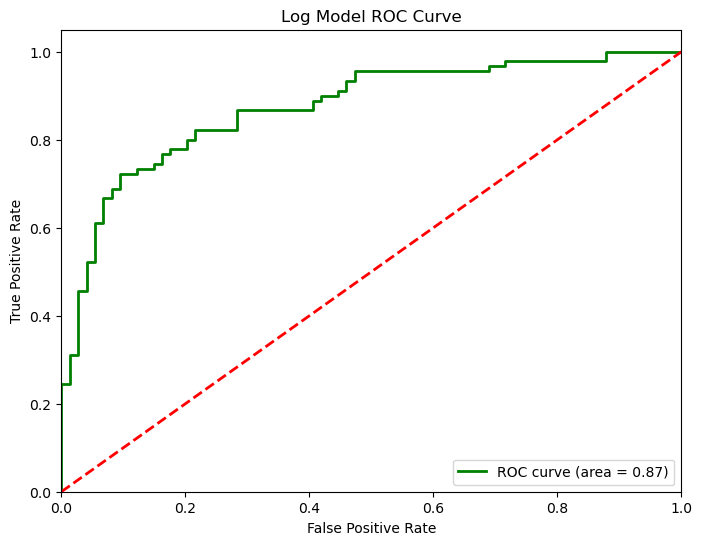

KNN ROC AUC: 0.87


In [37]:
# Probabilities
probs = log_fitted.predict_proba(X_test)
# Positive outcomes only, 0 to 1
probs = probs[:, 1]

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log Model ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"KNN ROC AUC: {roc_auc:.2f}")

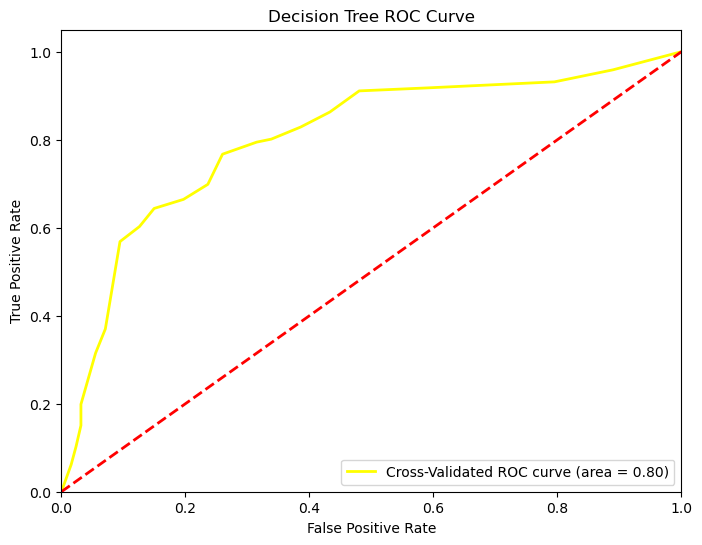

In [42]:
from sklearn.model_selection import cross_val_predict

# Predicted probabilities from CV
probs = cross_val_predict(decision_tree_optimal_pipeline, X, y, cv=5, method='predict_proba')

# Positive outcomes only
probs = probs[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='yellow', lw=2, label=f'Cross-Validated ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Part Two: Metrics

Consider the following metrics:

- True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?
- Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?
- True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [43]:
#Get metrics from KNN
tn, fp, fn, tp = knnconf_matrix.ravel()

#Calc metrics
knnprecision = tp / (tp + fp)  
knnrecall = tp / (tp + fn)    
knnspecificity = tn / (tn + fp)  


print(f"KNN Precision: {knnprecision}")
print(f"KNN Recall (True Positive Rate): {knnrecall}")
print(f"KNN Specificity (True Negative Rate): {knnspecificity}")

KNN Precision: 0.9245283018867925
KNN Recall (True Positive Rate): 0.5444444444444444
KNN Specificity (True Negative Rate): 0.9459459459459459


In [44]:
#Get metrics from Log model

tn, fp, fn, tp = logconf_matrix.ravel()

#Calc metrics
logprecision = tp / (tp + fp)  
logrecall = tp / (tp + fn)    
logspecificity = tn / (tn + fp)  


print(f"Logistic Model Precision: {logprecision}")
print(f"Logistic Model Recall (True Positive Rate): {logrecall}")
print(f"Logistic Model Specificity (True Negative Rate): {logspecificity}")

Logistic Model Precision: 0.8589743589743589
Logistic Model Recall (True Positive Rate): 0.7444444444444445
Logistic Model Specificity (True Negative Rate): 0.8513513513513513


In [46]:
#Get metrics from DT

tn, fp, fn, tp = decision_tree_conf_matrix.ravel()

#Calc metrics
dtprecision = tp / (tp + fp)  
dtrecall = tp / (tp + fn)    
dtspecificity = tn / (tn + fp)  


print(f"Decision Tree Precision: {dtprecision}")
print(f"Decision Tree Recall (True Positive Rate): {dtrecall}")
print(f"Decision Tree Specificity (True Negative Rate): {dtspecificity}")

Decision Tree Precision: 0.7906976744186046
Decision Tree Recall (True Positive Rate): 0.7555555555555555
Decision Tree Specificity (True Negative Rate): 0.7567567567567568


# Part Three: Discussion

Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:
- Which metric(s) you would use for model selection and why.
- Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.
- What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

## Q1

### The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

- I would go with the model that has the highest True Positive Rate, meaning the highest sensitivity. This would prioritize the minimization of false negatives, meaning labeling someone as not at risk when they actually are. The Decision Tree Model just edges out Logistic Regression Model in TPR, so it would be the ideal model for this scenario.We would expect about 76% of at risk patients to be correctly identified.

## Q2

The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

- This is a situation where only those that are most in need of medical attention should be labeled as at risk. Precision is important here because the hospital want to be efficient with the space they are using for people that are potentially at risk. In this case, the KNN model is clearly the most precise. About 92% of diagnoses are considered accurate.

## Q3

The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

- A situation like this would require us to be able to interpret the coefficients of a model, which I was only able to do with the Logistic Regression Model. A decision tree model could also allow for this, but since the Logistic Regression Model had a better ROC AUC score, I would go with that instead.

## Q4

The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

- It would be nice to use a model that has both a good TPR and Precision rate for this scenario, so we can compare our results to the diagnoses ofr new doctors. The KNN or Logistic regression models both have a high Precision, with KNN being much larger, Log Reg being smaller, but the opposite for their sensitivities.

# Part Four: Validation

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [53]:
# Load in validation set and apply same changes to assess prediction performance
validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
validation = validation.dropna()
validation.rename(columns={'output': 'atrisk', 'cp': 'chestpain', 'trtbps': 'rbp', 'thalach': 'maxrate'}, inplace=True)
validation['atrisk'] = validation['atrisk'].astype('category')
validation['sex'] = validation['sex'].astype('category')
validation['chestpain'] = validation['chestpain'].astype('category')
validation['restecg'] = validation['restecg'].astype('category')
validation.head()

,age,sex,chestpain,rbp,chol,restecg,maxrate,atrisk
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [54]:
X_val = validation.drop(["atrisk"],axis=1)
y_val = validation["atrisk"]

## KNN Validation

In [60]:
knn_val_pred = knn_optimal_pipeline.predict(X_val)
knn_val_pred_proba = knn_optimal_pipeline.predict_proba(X_val)[:, 1]  

# Calculate metrics
knn_val_roc_auc = roc_auc_score(y_val, knn_val_pred_proba)
knn_val_precision = precision_score(y_val, knn_val_pred)
knn_val_recall = recall_score(y_val, knn_val_pred)

# Confusion Matrix
knn_val_conf_matrix = confusion_matrix(y_val, knn_val_pred)

# Print results
print("KNN Validation Confusion Matrix:")
print(knn_val_conf_matrix)
print(f"KNN Validation ROC AUC: {knn_val_roc_auc}")
print(f"KNN Validation Precision: {knn_val_precision}")
print(f"KNN Validation Recall: {knn_val_recall}")

KNN Validation Confusion Matrix:
[[11  0]
 [ 9 10]]
KNN Validation ROC AUC: 0.8349282296650719
KNN Validation Precision: 1.0
KNN Validation Recall: 0.5263157894736842


#### Results

ROC AUC seemed to improve slightly, while precision improved dramatically, up to 100% The only concern here is that it had a very low True Positive Rate, which could be a concern in some of the scenarios above.

## Logistic Regression Validation

In [58]:
# Validation
log_val_pred = log_pipeline.predict(X_val)
log_val_pred_proba = log_pipeline.predict_proba(X_val)[:, 1]  

# Calculate metrics
log_val_roc_auc = roc_auc_score(y_val, log_val_pred_proba)
log_val_precision = precision_score(y_val, log_val_pred)
log_val_recall = recall_score(y_val, log_val_pred)

# Confusion Matrix
log_val_conf_matrix = confusion_matrix(y_val, log_val_pred)

# Print results
print("LOG Validation Confusion Matrix:")
print(log_val_conf_matrix)
print(f"LOG Validation ROC AUC: {log_val_roc_auc}")
print(f"LOG Validation Precision: {log_val_precision}")
print(f"LOG Validation Recall: {log_val_recall}")

LOG Validation Confusion Matrix:
[[ 9  2]
 [ 6 13]]
LOG Validation ROC AUC: 0.8708133971291866
LOG Validation Precision: 0.8666666666666667
LOG Validation Recall: 0.6842105263157895


#### Results

ROC AUC and Precision barely improved at all, while recall dropped from the 70s down to 68. This doesn't seem to make the Logistic Regression model very promising, which is unfortunate as it had the highest ROC AUC score.

In [61]:
# DT Validation
dt_val_pred = decision_tree_optimal_pipeline.predict(X_val)
dt_val_pred_proba = decision_tree_optimal_pipeline.predict_proba(X_val)[:, 1]  

# Calculate metrics
dt_val_roc_auc = roc_auc_score(y_val, dt_val_pred_proba)
dt_val_precision = precision_score(y_val, dt_val_pred)
dt_val_recall = recall_score(y_val, dt_val_pred)

# Confusion Matrix
dt_val_conf_matrix = confusion_matrix(y_val, dt_val_pred)

# Print the results
print("DT Validation Confusion Matrix:")
print(dt_val_conf_matrix)
print(f"DT Validation ROC AUC: {dt_val_roc_auc}")
print(f"DT Validation Precision: {dt_val_precision}")
print(f"DT Validation Recall: {dt_val_recall}")


DT Validation Confusion Matrix:
[[10  1]
 [ 5 14]]
DT Validation ROC AUC: 0.8229665071770335
DT Validation Precision: 0.9333333333333333
DT Validation Recall: 0.7368421052631579


#### Results

ROC AUC went up slightly from .819 to .823. However Precision went up drastically from .79 to .93, while Recall dropped from 75 to 73. This model seems to hold up as it has a very similiar ROC AUC score, improves its precision, and doesn't drop the recall too much.

# Part Five: Cohen’s Kappa
Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [65]:
from sklearn.metrics import cohen_kappa_score

#Cohen's Kappa of each model
knn_cohen = cohen_kappa_score(y_test,y_pred_knn)
log_cohen = cohen_kappa_score(y_test,y_pred_log)
dt_cohen = cohen_kappa_score(y_test,y_pred_tree)

print(f"CK scorefor K-Nearest Neighbors: {knn_cohen}")
print(f"CK score for Logistic Regression: {log_cohen}")
print(f"CK score for Decision Tree: {dt_cohen}")

CK scorefor K-Nearest Neighbors: 0.4695227142035653
CK score for Logistic Regression: 0.5873297809354647
CK score for Decision Tree: 0.5098625224148237


The Kappa score of .47 for KNN is moderate. It might make sense to use this metric if it is costly to misdiagnose patients.

The Kappy score of .59 for Logistic Regression is the best of the three models, which strengthens the original decision from parts 1 and 2 that Log Reg is the best model to use. 

Same thing for KNN applies to decision tree model, but also seems to indicate the conclusion from part 1 that DTree is not a substantial model.